In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:34731")
client

<Client: 'tcp://127.0.0.1:34731' processes=8 threads=32, memory=187.53 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
# import numpy_groupies
from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture as BGM
from sklearn.cluster import KMeans
import dask.array as dsar
import xrft
import qgutils
from xgcm.grid import Grid
import os.path as op
# from dask.diagnostics import ProgressBar
import matplotlib
matplotlib.rcParams['pcolor.shading'] = 'auto'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
%matplotlib inline

In [3]:
ddir = '/bettik/uchidat/qg-ML/'

In [4]:
dsp1 = xr.open_dataset(op.join(ddir,"Eddy-n04_001.nc"))
dsp1

<xarray.Dataset>
Dimensions:  (XC: 256, YC: 256, Z: 3, time: 312)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 ...
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0
Data variables:
    upqp     (time, Z, YC, XC) float32 ...
    vpqp     (time, Z, YC, XC) float32 ...
    upP0p    (time, Z, YC, XC) float32 ...
    vpP0p    (time, Z, YC, XC) float32 ...
    upP1p    (time, Z, YC, XC) float32 ...
    vpP1p    (time, Z, YC, XC) float32 ...
    upP2p    (time, Z, YC, XC) float32 ...
    vpP2p    (time, Z, YC, XC) float32 ...
    upP3p    (time, Z, YC, XC) float32 ...
    vpP3p    (time, Z, YC, XC) float32 ...

In [5]:
dsp1.upP0p.isel(Z=0,time=slice(None,-63)).data.ravel().shape

(16318464,)

In [5]:
iZ = 0
ntrain = 2
ntime = int(ntrain*63)
nflat = int(len(dsp1.time.isel(time=slice(None,-ntime)))*256*256)
nflat

12189696

In [6]:
nGMM = 31
# nKM = 9

In [7]:
X = dsp1.upP0p.isel(Z=iZ,time=slice(None,-ntime)).data.ravel().reshape((nflat,1))
X = np.concatenate((X,dsp1.vpP0p.isel(Z=iZ,time=slice(None,-ntime)).data.ravel().reshape((nflat,1))),axis=1)
X = np.concatenate((X,dsp1.upP1p.isel(Z=iZ,time=slice(None,-ntime)).data.ravel().reshape((nflat,1))),axis=1)
X = np.concatenate((X,dsp1.vpP1p.isel(Z=iZ,time=slice(None,-ntime)).data.ravel().reshape((nflat,1))),axis=1)
X = np.concatenate((X,dsp1.upP2p.isel(Z=iZ,time=slice(None,-ntime)).data.ravel().reshape((nflat,1))),axis=1)
X = np.concatenate((X,dsp1.vpP2p.isel(Z=iZ,time=slice(None,-ntime)).data.ravel().reshape((nflat,1))),axis=1)
X = np.concatenate((X,dsp1.upP3p.isel(Z=iZ,time=slice(None,-ntime)).data.ravel().reshape((nflat,1))),axis=1)
X = np.concatenate((X,dsp1.vpP3p.isel(Z=iZ,time=slice(None,-ntime)).data.ravel().reshape((nflat,1))),axis=1)
X

array([[-1.71368639e-03,  1.88574090e-03, -1.33659202e-03, ...,
         4.26557939e-03, -3.32796876e-03,  3.33738467e-03],
       [-6.23987289e-03,  4.13750485e-03, -3.37547483e-03, ...,
         3.95834725e-03, -8.44979472e-03,  2.58532399e-03],
       [-1.17785735e-02,  5.71077410e-03, -4.75266390e-03, ...,
         3.28105176e-03, -1.15432516e-02,  1.74856465e-03],
       ...,
       [ 1.14975460e-08,  1.12022003e-09, -4.64645211e-09, ...,
         3.90078281e-09, -1.78675954e-08, -3.15811688e-09],
       [ 8.65062866e-09, -1.89498617e-09, -4.70377381e-09, ...,
        -5.48444534e-09, -1.57246554e-08,  1.07382658e-09],
       [ 3.21554117e-09, -3.15113757e-09, -2.09424855e-09, ...,
        -9.41319378e-09, -6.60468036e-09,  5.76547787e-09]], dtype=float32)

In [8]:
# gm = GMM(n_components=nGMM, random_state=0, n_init=4, 
#          max_iter=200
#         ).fit(X)
# gm.means_
gm = BGM(n_components=nGMM, random_state=0, n_init=4, 
         max_iter=200
        ).fit(X)
gm.means_
######################
# km = KMeans(n_clusters=nKM, random_state=0
# #          max_iter=100, n_init=4,
#            ).fit(X)
# km.labels_

MemoryError: Unable to allocate 744. MiB for an array with shape (12189696, 8) and data type float64

In [ ]:
import pickle
# filename = ddir+'GMM%02d_UpPp.sav' % nGMM
filename = ddir+'BGM%02d_UpPp.sav' % nGMM
pickle.dump(gm, open(filename, 'wb'))
# gm = pickle.load(open(filename, 'rb'))

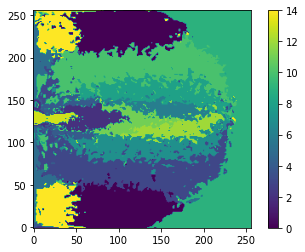

<xarray.DataArray (time: 126, YC: 256, XC: 256)>
dask.array<xarray-<this-array>, shape=(126, 256, 256), dtype=int64, chunksize=(126, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * time     (time) float64 497.0 498.0 499.0 500.0 ... 619.0 620.0 621.0 622.0


In [9]:
ver = 1

for i in range(-ntime,0):
    
    Y = dsp1.upP0p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))
    Y = np.concatenate((Y,dsp1.vpP0p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,dsp1.upP1p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,dsp1.vpP1p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,dsp1.upP2p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,dsp1.vpP2p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,dsp1.upP3p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,dsp1.vpP3p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))),axis=-1)
    
    if i == -ntime:
        category = np.reshape(gm.predict(Y),(1,256,256))
#         category = np.reshape(km.predict(Y),(1,256,256))
        plt.imshow(category[0], origin='lower')
        plt.colorbar()
        plt.show()
    else:
        category = np.concatenate((category, np.reshape(gm.predict(Y),(1,256,256))),
                                  axis=0)
#         category = np.concatenate((category, np.reshape(km.predict(Y),(1,256,256))),
#                                   axis=0)
        
category = xr.DataArray(category, dims=dsp1.upP0p.isel(Z=iZ,time=slice(-ntime,None)).dims, 
                        coords=dsp1.upP0p.isel(Z=iZ,time=slice(-ntime,None)).coords
                       ).chunk({'YC':128,'XC':128}).reset_coords(drop=True)
print(category)

# category.to_dataset(name='cluster').to_zarr(op.join(ddir,'EddyPTRCluster/GMM%02d/%03d/Z%02d/'
#                                                     % (nGMM,ver,iZ)),
#                                             mode='w')
category.to_dataset(name='cluster').to_zarr(op.join(ddir,'EddyPTRCluster/BGM%02d/%03d/Z%02d/'
                                                    % (nGMM,ver,iZ)),
                                            mode='w')
# category.to_dataset(name='cluster').to_zarr(op.join(ddir,'EddyPTRCluster/KMeans%02d/%03d/Z%02d/'
#                                                     % (nKM,ver,iZ)),
#                                             mode='w')

<xarray.DataArray (time: 312, YC: 256, XC: 256)>
dask.array<xarray-<this-array>, shape=(312, 256, 256), dtype=int64, chunksize=(312, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * time     (time) float64 622.0 623.0 624.0 625.0 ... 930.0 931.0 932.0 933.0


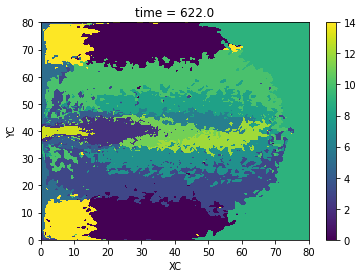

In [10]:
ver = 2
dsp2 = xr.open_dataset(op.join(ddir,"Eddy-n04_002.nc"))

for i in range(len(dsp2.time)):
    
    Y = dsp2.upP0p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))
    Y = np.concatenate((Y,dsp2.vpP0p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,dsp2.upP1p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,dsp2.vpP1p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,dsp2.upP2p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,dsp2.vpP2p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,dsp2.upP3p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))),axis=-1)
    Y = np.concatenate((Y,dsp2.vpP3p.isel(Z=iZ,time=i).data.ravel().reshape((int(256*256),1))),axis=-1)
    
    if i == 0:
        category = np.reshape(gm.predict(Y),(1,256,256))
#         category = np.reshape(km.predict(Y),(1,256,256))
    else:
        category = np.concatenate((category, np.reshape(gm.predict(Y),(1,256,256))),
                                  axis=0)
#         category = np.concatenate((category, np.reshape(km.predict(Y),(1,256,256))),
#                                   axis=0)
        
category = xr.DataArray(category, dims=dsp2.upP0p.isel(Z=iZ).dims, 
                        coords=dsp2.upP0p.isel(Z=iZ).coords
                       ).chunk({'YC':128,'XC':128}).reset_coords(drop=True)
print(category)
category.isel(time=0).plot()
plt.show()

# category.to_dataset(name='cluster').to_zarr(op.join(ddir,'EddyPTRCluster/GMM%02d/%03d/Z%02d/'
#                                                     % (nGMM,ver,iZ)),
#                                             mode='w')
category.to_dataset(name='cluster').to_zarr(op.join(ddir,'EddyPTRCluster/BGM%02d/%03d/Z%02d/'
                                                    % (nGMM,ver,iZ)),
                                            mode='w')
# category.to_dataset(name='cluster').to_zarr(op.join(ddir,'EddyPTRCluster/KMeans%02d/%03d/Z%02d/'
#                                                     % (nKM,ver,iZ)),
#                                             mode='w')

In [6]:
def colorbar_index(ncolors, cmap):
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))

def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in np.arange(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

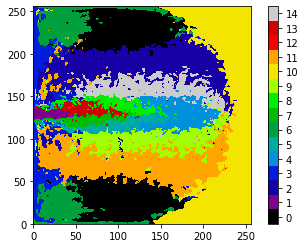

In [7]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('nipy_spectral')
ax.pcolormesh(xr.open_zarr(op.join(ddir,'EddyPTRCluster/GMM%02d/%03d/Z%02d/' 
                                   % (nGMM,1,0))).cluster.isel(time=10), cmap=cmap)
colorbar_index(ncolors=nGMM, cmap=cmap)
ax.set_aspect('equal')

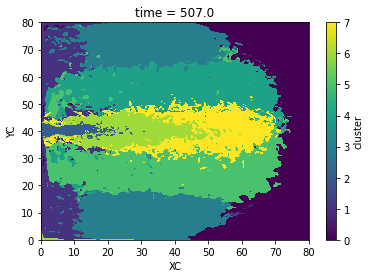

In [15]:
xr.open_zarr(op.join(ddir,'EddyPTRCluster/GMM%02d/%03d/Z%02d/' % (8,1,0))).cluster.isel(time=10).plot()

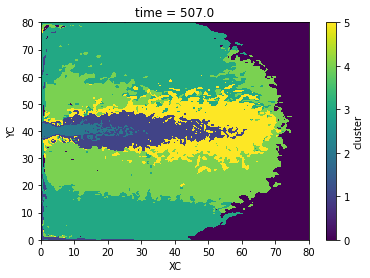

In [14]:
xr.open_zarr(op.join(ddir,'EddyPTRCluster/GMM%02d/%03d/Z%02d/' % (6,1,0))).cluster.isel(time=10).plot()

In [31]:
dsc = xr.open_zarr(op.join(ddir,'EddyPTRCluster/GMM%02d/%03d/Z%02d/' % (9,1,0)))
dsc

<xarray.Dataset>
Dimensions:  (XC: 256, YC: 256, time: 126)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * time     (time) float64 497.0 498.0 499.0 500.0 ... 619.0 620.0 621.0 622.0
Data variables:
    cluster  (time, YC, XC) int64 dask.array<chunksize=(126, 128, 128), meta=np.ndarray>

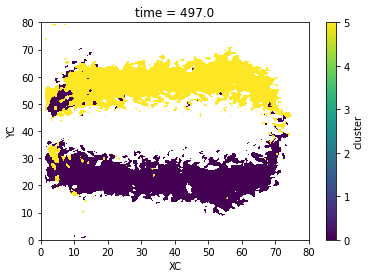

In [47]:
dsc.cluster.where((dsc.cluster==5) | (dsc.cluster==0)).isel(time=0).plot()

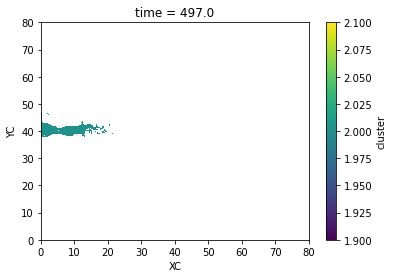

In [51]:
dsc.cluster.where(dsc.cluster==2).isel(time=0).plot()

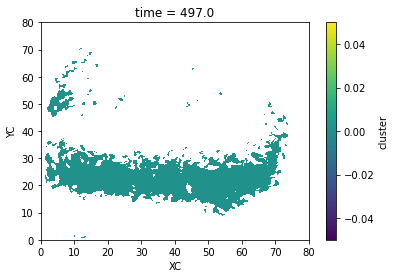

In [43]:
dsc.cluster.where(dsc.cluster==0).isel(time=0).plot()